# Analyzing Sea Ice Data

Decomposition of monthly sea ice data from the National Snow and Ice Data Center's [Data Archive](https://nsidc.org/data/seaice_index/data-and-image-archive).

Notebook by Will Geary [@wgeary](https://twitter.com/wgeary).

# Set up

## Import libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from bs4 import BeautifulSoup
import requests
from prophet import Prophet

# Provide an unverified SSL context
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

# Hide Stanpy logs
import logging
logger = logging.getLogger('cmdstanpy')
logger.addHandler(logging.NullHandler())
logger.propagate = False
logger.setLevel(logging.CRITICAL)

## Utility functions

In [2]:
def list_files(url, ext='csv'):
    page = requests.get(url).text
    soup = BeautifulSoup(page, 'html.parser')
    return [url + '/' + node.get('href') for node in soup.find_all('a') if node.get('href').endswith(ext)]

In [3]:
def get_monthly_sea_ice_data(region):
    if region == 'antarctic':
        url = "https://masie_web.apps.nsidc.org/pub/DATASETS/NOAA/G02135/south/monthly/data"
        files = list_files(url)
    elif region == 'arctic':
        url = "https://masie_web.apps.nsidc.org/pub/DATASETS/NOAA/G02135/north/monthly/data"
        files = list_files(url)
    df = pd.concat([pd.read_csv(i) for i in files])
    df.columns = [i.strip() for i in df.columns]
    df.index = pd.to_datetime(df['year'].astype(str) + "-" + df['mo'].apply(lambda x: str(x).zfill(2)))
    df = df.drop(columns=['year', 'mo'])
    # Missing values are filled with -9999. Drop them.
    df = df[df['area']!=-9999]
    df = df[df['extent']!=-9999]
    df = df.resample('m').mean('numeric_only')
    return df

In [4]:
def seasonality_plot_df(m, ds):
    """Prepare dataframe for plotting seasonal components.
    Parameters
    ----------
    m: Prophet model.
    ds: List of dates for column ds.
    Returns
    -------
    A dataframe with seasonal components on ds.
    """
    df_dict = {'ds': ds, 'cap': 1., 'floor': 0.}
    for name in m.extra_regressors:
        df_dict[name] = 0.
    # Activate all conditional seasonality columns
    for props in m.seasonalities.values():
        if props['condition_name'] is not None:
            df_dict[props['condition_name']] = True
    df = pd.DataFrame(df_dict)
    df = m.setup_dataframe(df)
    return df

In [5]:
def plot_seasonal_component(model, ax):
    days = (pd.date_range(start='2017-01-01', periods=365))
    df_y = seasonality_plot_df(model, days)
    seas = model.predict_seasonal_components(df_y)
    seas.index = df_y['ds']
    month_seas = seas[['yearly_lower', 'yearly_upper']].resample('m').mean()
    month_seas['error'] = month_seas['yearly_upper'] - month_seas['yearly_lower']
    month_seas['yearly_midpoint'] = (month_seas['yearly_lower'] + month_seas['yearly_upper'])/2
    month_seas.index = pd.Series(month_seas.index).apply(lambda x: x.strftime('%B'))
    month_seas[['yearly_midpoint']].plot(kind='barh', legend=False, title='Seasonal Component', xerr=month_seas['error'], align='center', alpha=0.5, ecolor='black', capsize=2, ax=ax)
    ax.set(ylabel=None)
    #ax.set_xlim(-6,6)
    plt.gca().invert_yaxis()
    return ax

In [6]:
def fit_model(df, col):
    df = df.copy()
    df['ds'] = df.index
    df['y'] = df[col]
    model = Prophet(interval_width=0.95, mcmc_samples=300, yearly_seasonality=False, weekly_seasonality=False)
    model.add_seasonality(name='yearly', period=365.25, fourier_order=5)
    model.fit(df, show_progress=False)
    future = model.make_future_dataframe(periods=0)
    forecast = model.predict(future)
    forecast.index = forecast['ds'].dt.to_pydatetime()
    return model, forecast

In [7]:
def plot_trend_and_seasonal_components(model, forecast, title):
    fig = plt.figure(figsize=(14, 8), constrained_layout=False, dpi=120)
    gs = fig.add_gridspec(20, 20)
    fig.suptitle(title, fontsize=16)
    ax1 = fig.add_subplot(gs[0:10, 0:13])
    forecast['trend'].plot(title='Trend Component', ylabel='Millions of KM$^2$',ax=ax1)
    ax1.fill_between(forecast.index, forecast['trend_lower'], forecast['trend_upper'],
            color='#0072B2', alpha=0.2)
    ax1.set_ylim(bottom=0)
    ax2 = fig.add_subplot(gs[0:10, 15:20])
    plot_seasonal_component(model, ax2)
    fig.subplots_adjust(top=0.90);

# Get the data

## Arctic

In [8]:
arctic = get_monthly_sea_ice_data(region='arctic')

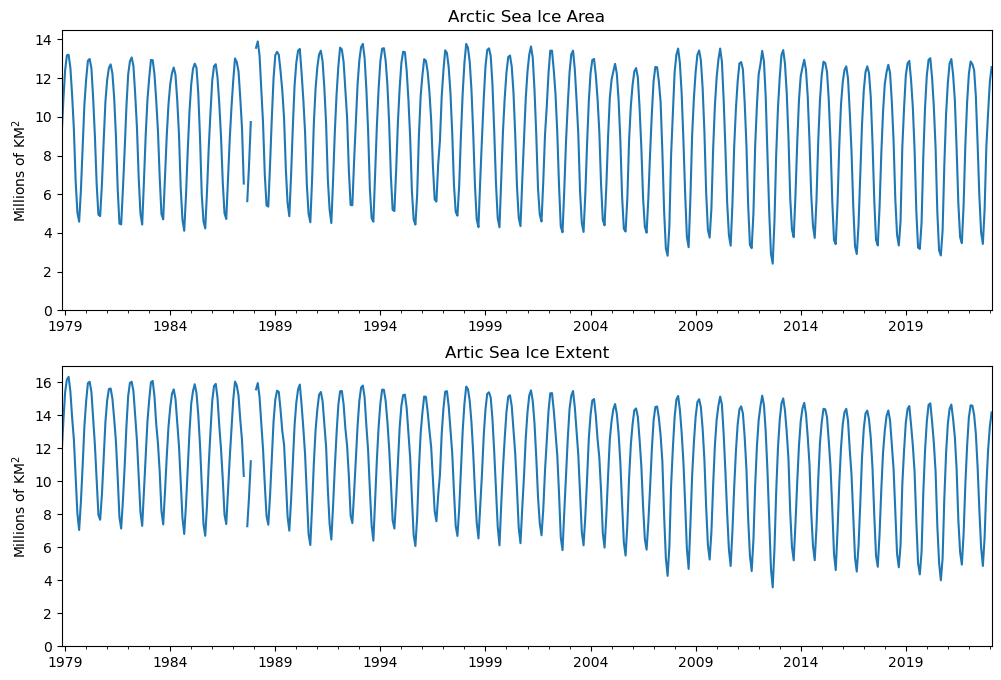

In [9]:
fig, (ax1, ax2) = plt.subplots(2,1,figsize=(12,8))
arctic['area'].plot(ax=ax1, title='Arctic Sea Ice Area', ylabel='Millions of KM$^2$')
arctic['extent'].plot(ax=ax2, title='Artic Sea Ice Extent', ylabel='Millions of KM$^2$')
ax1.set_ylim(bottom=0)
ax2.set_ylim(bottom=0);

## Antarctic

In [10]:
antarctic = get_monthly_sea_ice_data(region='antarctic')

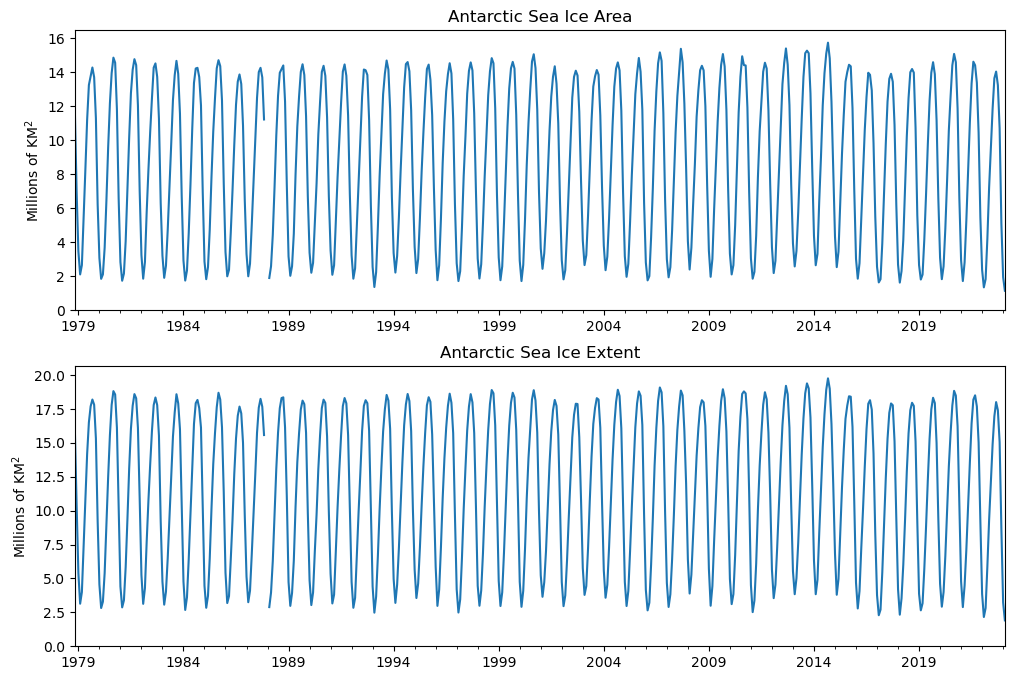

In [11]:
fig, (ax1, ax2) = plt.subplots(2,1,figsize=(12,8))
antarctic['area'].plot(ax=ax1, title='Antarctic Sea Ice Area', ylabel='Millions of KM$^2$')
antarctic['extent'].plot(ax=ax2, title='Antarctic Sea Ice Extent', ylabel='Millions of KM$^2$')
ax1.set_ylim(bottom=0)
ax2.set_ylim(bottom=0);

# Seasonal Decomposition

## Arctic Sea Ice Area

In [12]:
model, forecast = fit_model(arctic, col='area')

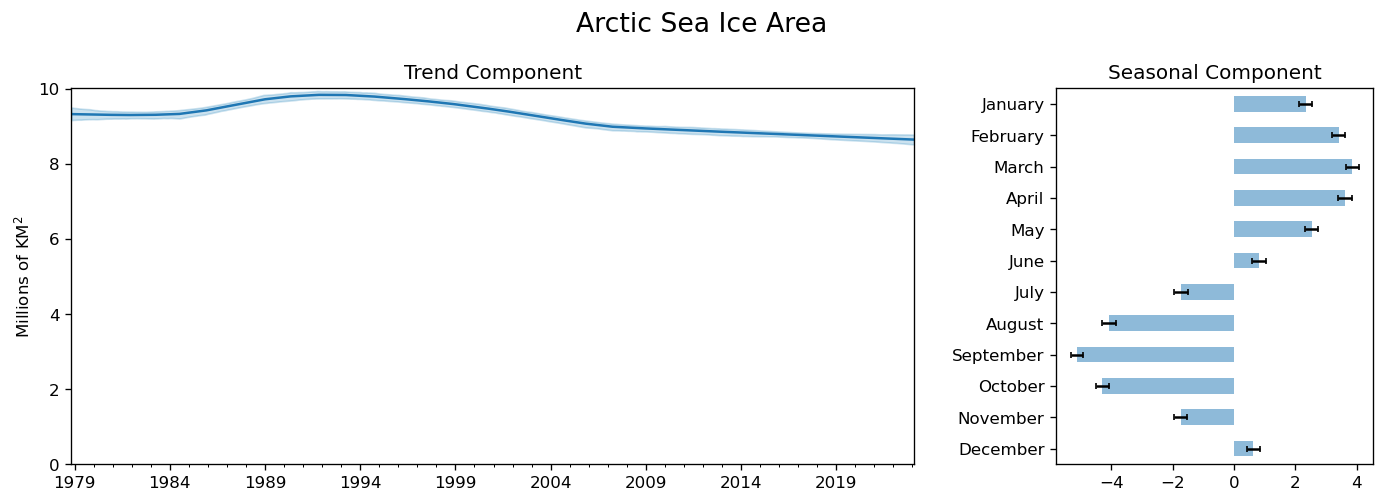

In [13]:
plot_trend_and_seasonal_components(model, forecast, title='Arctic Sea Ice Area')

## Arctic Sea Ice Extent 

In [14]:
model, forecast = fit_model(arctic, col='extent')

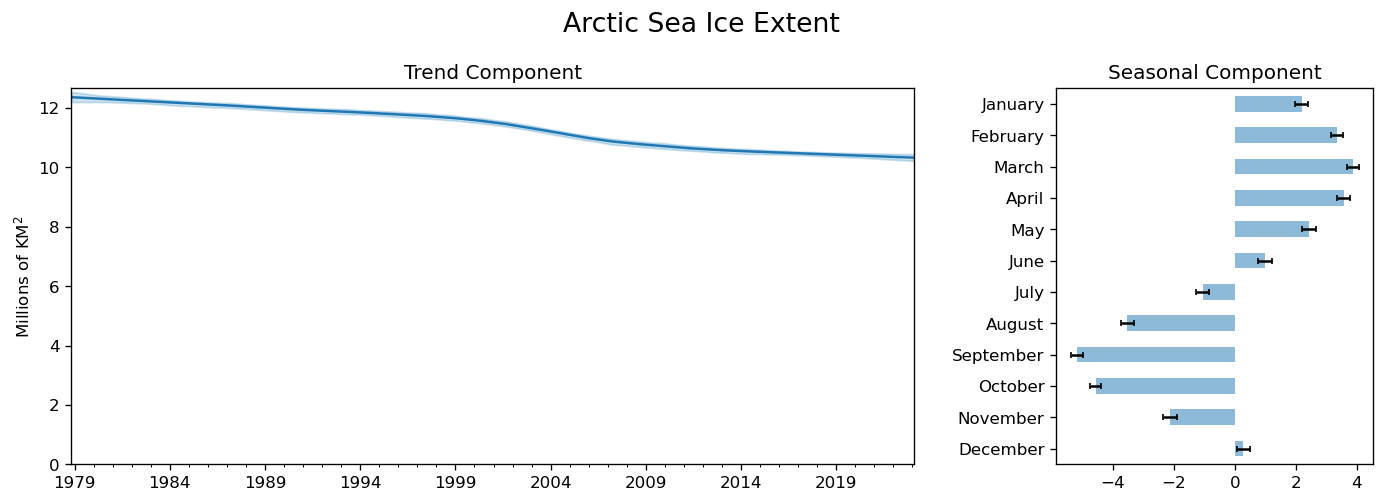

In [15]:
plot_trend_and_seasonal_components(model, forecast, title='Arctic Sea Ice Extent')

## Antarctic Sea Ice Area

In [16]:
model, forecast = fit_model(antarctic, col='area')

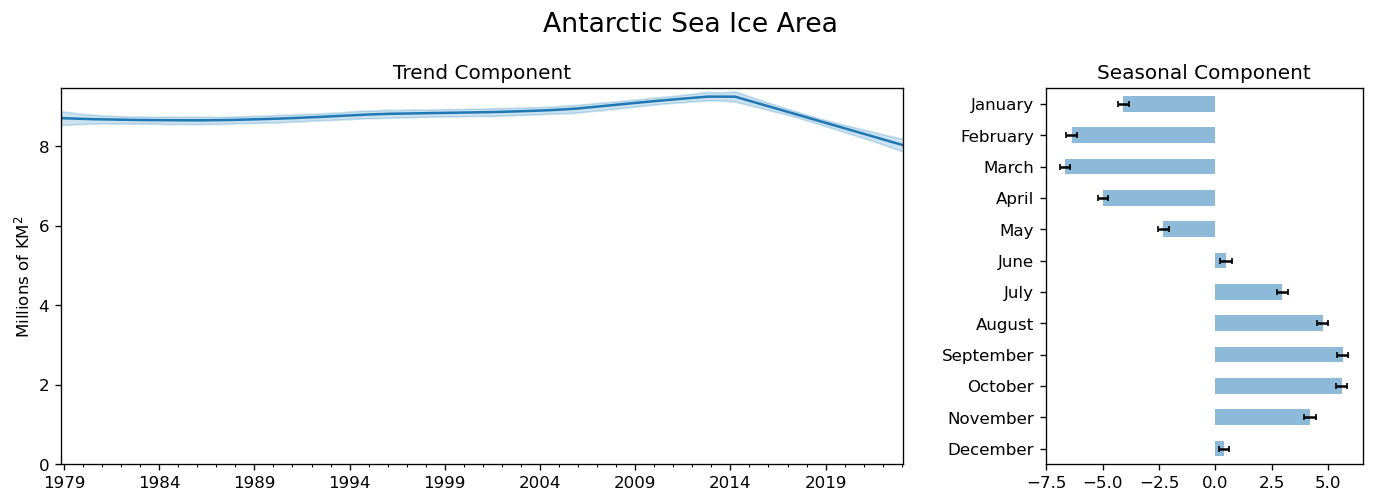

In [17]:
plot_trend_and_seasonal_components(model, forecast, title='Antarctic Sea Ice Area')

## Antarctic Sea Ice Extent

In [18]:
model, forecast = fit_model(antarctic, col='extent')

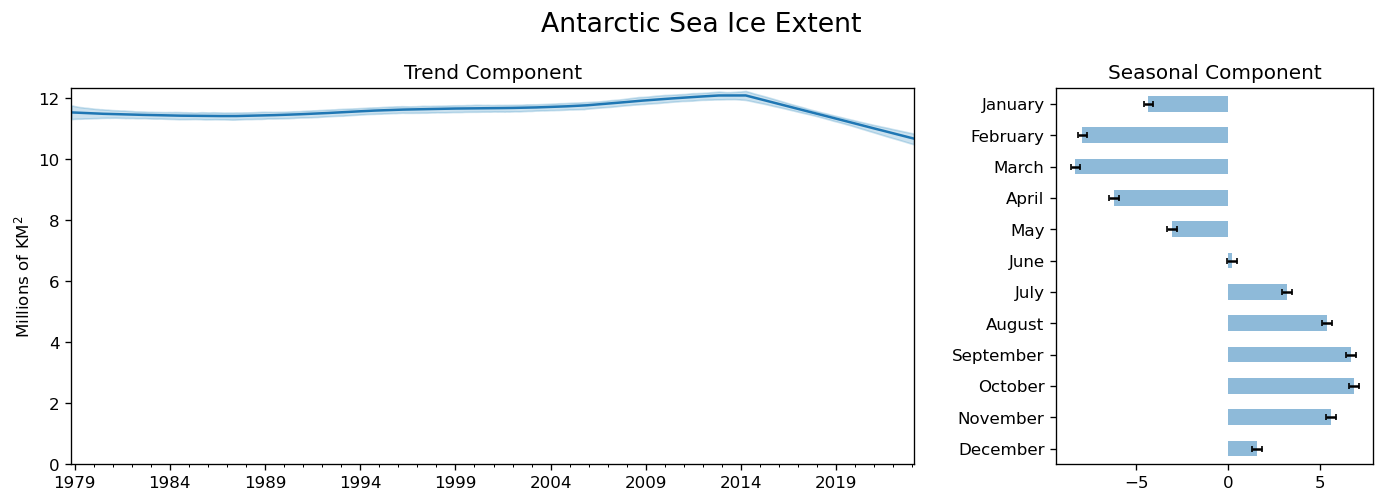

In [19]:
plot_trend_and_seasonal_components(model, forecast, title='Antarctic Sea Ice Extent')